In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, NaiveBayes, LinearSVC
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
spark = SparkSession.builder.appName("Kelompok4_UAS").getOrCreate()

In [ ]:
file_path = "/content/diabetes.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
df.show(5, truncate=False)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI |DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|6          |148    |72           |35           |0      |33.6|0.627                   |50 |1      |
|1          |85     |66           |29           |0      |26.6|0.351                   |31 |0      |
|8          |183    |64           |0            |0      |23.3|0.672                   |32 |1      |
|1          |89     |66           |23           |94     |28.1|0.167                   |21 |0      |
|0          |137    |40           |35           |168    |43.1|2.288                   |33 |1      |
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



**Memeriksa Tipe Data Setiap Kolom**

In [ ]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



**Mengganti Nama Kolom**

In [ ]:
df = df.withColumnRenamed("Outcome", "Label")
df.show(5, truncate=False)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI |DiabetesPedigreeFunction|Age|Label|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----+
|6          |148    |72           |35           |0      |33.6|0.627                   |50 |1    |
|1          |85     |66           |29           |0      |26.6|0.351                   |31 |0    |
|8          |183    |64           |0            |0      |23.3|0.672                   |32 |1    |
|1          |89     |66           |23           |94     |28.1|0.167                   |21 |0    |
|0          |137    |40           |35           |168    |43.1|2.288                   |33 |1    |
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----+
only showing top 5 rows



**Memeriksa Nilai Null Pada Dataset**

In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-----+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Label|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-----+
|          0|      0|            0|            0|      0|  0|                       0|  0|    0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-----+



**Mengubah Tipe Data**

Seperti yang dapat dilihat pada tipe data yang ada, semua feature atau kolom sudah memiliki tipe data numerik sehingga semuanya sudah dapat diproses. Sehingga tahap ini tidak akan dilakukan.

**Menampilkan Summary**

In [ ]:
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|             Label|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

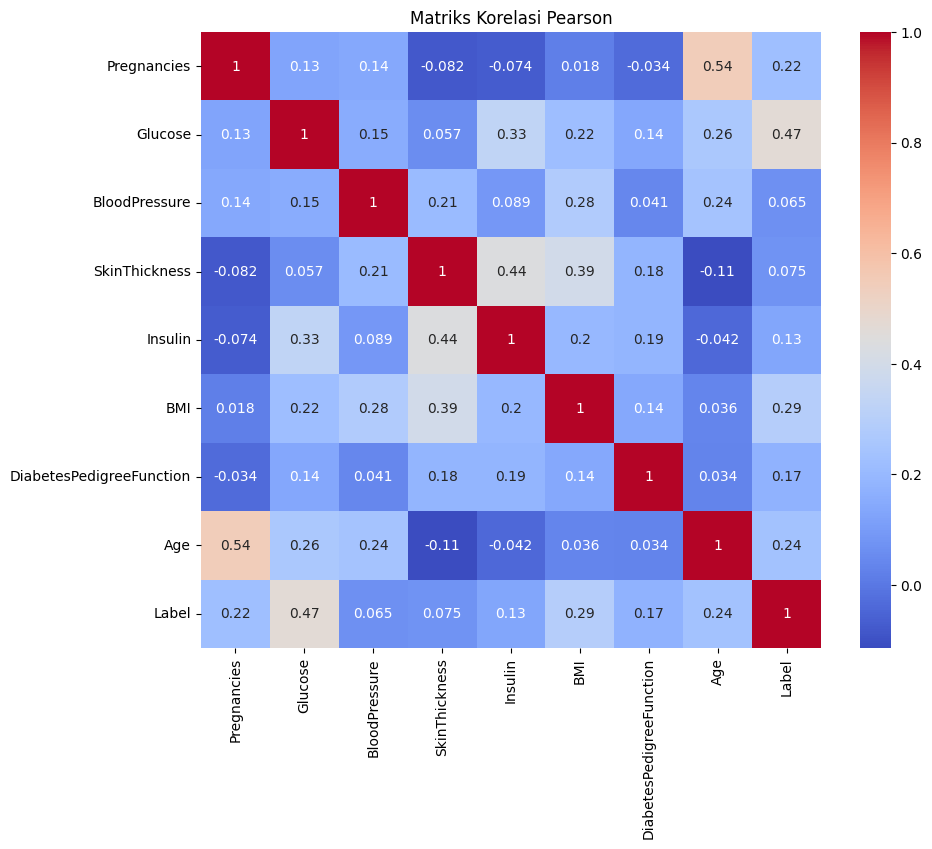

In [ ]:
numerical_cols = [col for col, dtype in df.dtypes if dtype in ['int', 'double']]

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
df_assembled = assembler.transform(df)

correlation_matrix = Correlation.corr(df_assembled, "features").head()[0]

corr_matrix = np.array(correlation_matrix.toArray())
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=numerical_cols, yticklabels=numerical_cols)
plt.title("Matriks Korelasi Pearson")
plt.show()

**Visualisasi Bar Chart Untuk Feature "Label"**

In [ ]:
df_pandas = df.toPandas()

<ipython-input-17-51ef3e36efd4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df_pandas, palette='Set2')


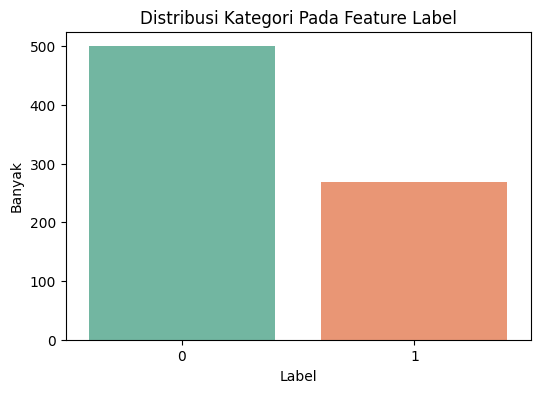

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=df_pandas, palette='Set2')
plt.title('Distribusi Kategori Pada Feature Label')
plt.xlabel('Label')
plt.ylabel('Banyak')
plt.show()

**Visualisasi Pie Chart Untuk Feature "Label"**

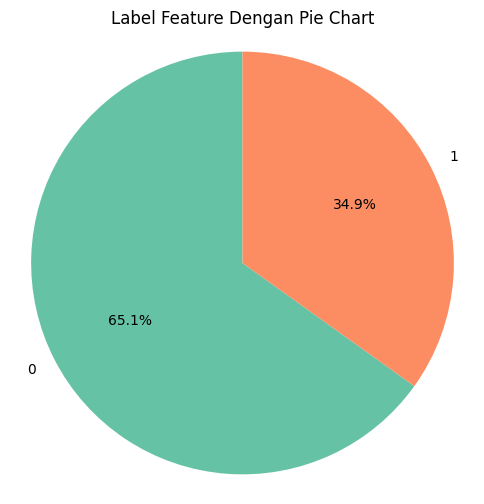

In [ ]:
label_counts = df_pandas['Label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", 2))
plt.title('Label Feature Dengan Pie Chart')
plt.axis('equal')
plt.show()

**Visualisasi Box Plot untuk Semua Feature**

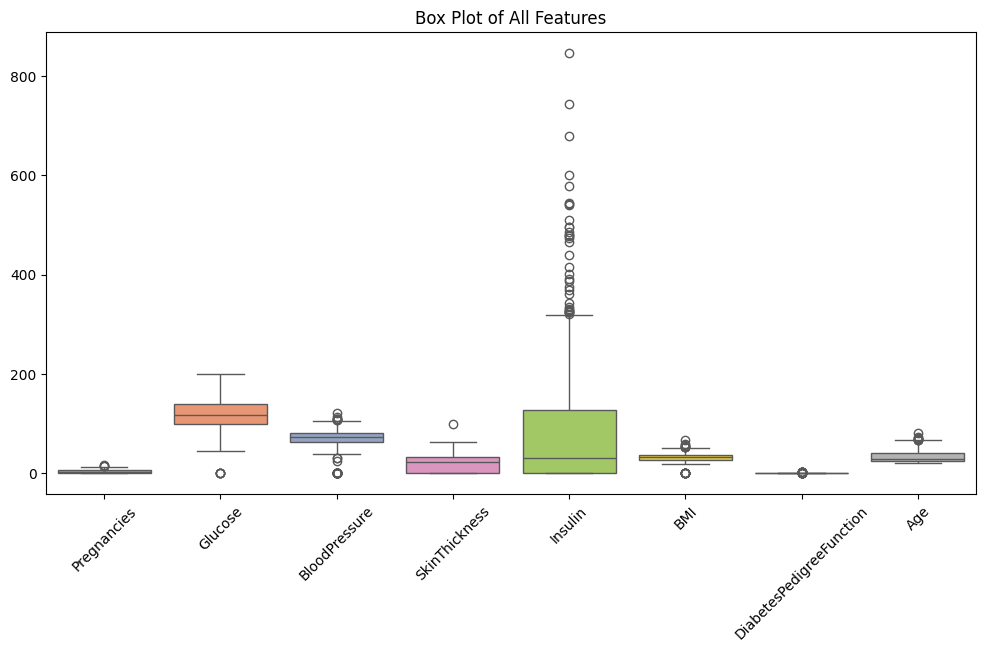

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pandas.drop(columns=['Label']), palette='Set2')
plt.title('Box Plot of All Features')
plt.xticks(rotation=45)
plt.show()

**Visualisasi Histogram untuk Feature "Age"**

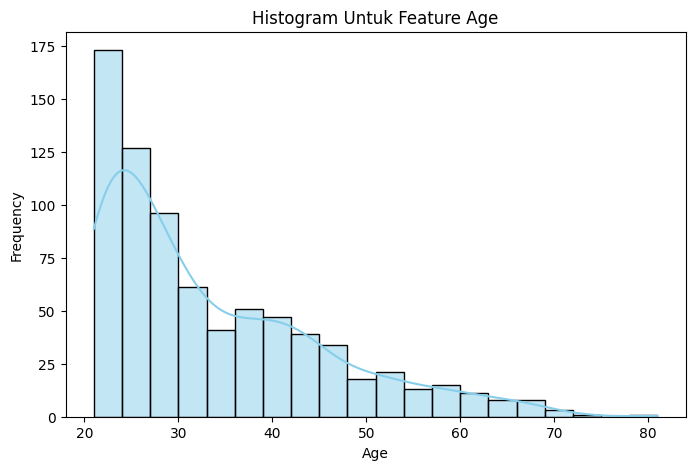

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_pandas['Age'], kde=True, color='skyblue', bins=20)
plt.title('Histogram Untuk Feature Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

#2.Pengembangan Machine Learning

In [ ]:
feature_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
def evaluate_model(model, train_data, test_data, model_name="Model"):
    pipeline = Pipeline(stages=[assembler, model])

    model_trained = pipeline.fit(train_data)
    predictions = model_trained.transform(test_data)

    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Label")
    auc = evaluator.evaluate(predictions)

    predictions_pd = predictions.select('Label', 'prediction').toPandas()
    print(f"{model_name} Classification Report:")
    print(classification_report(predictions_pd['Label'], predictions_pd['prediction']))

    fpr, tpr, thresholds = roc_curve(predictions_pd['Label'], predictions_pd['prediction'])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'{model_name} ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return auc

**Random Forest Classification**

Evaluating Random Forest Classifier
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        80
           1       0.75      0.63      0.68        43

    accuracy                           0.80       123
   macro avg       0.78      0.76      0.77       123
weighted avg       0.79      0.80      0.79       123



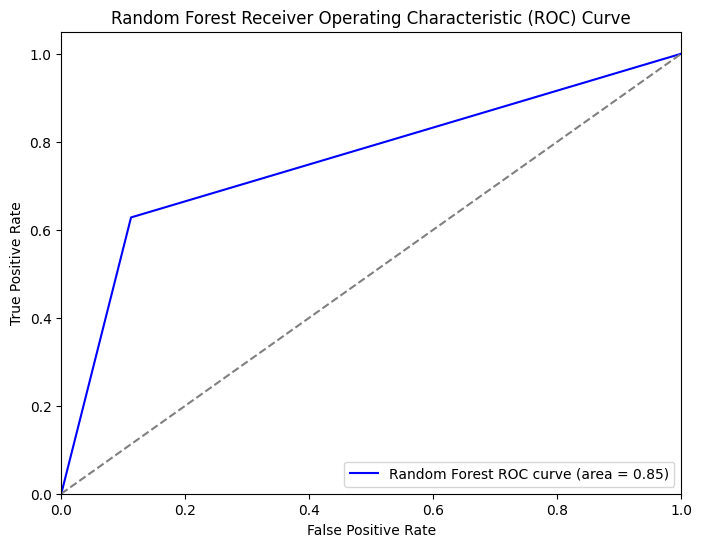

Random Forest AUC: 0.8476744186046513



In [ ]:
rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='Label')
print("Evaluating Random Forest Classifier")
rf_auc = evaluate_model(rf_classifier, train_data, test_data, model_name="Random Forest")
print(f"Random Forest AUC: {rf_auc}\n")

**Gradient Boosted Trees Classifier**

Evaluating Gradient Boosted Trees Classifier
Gradient Boosted Trees Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80        80
           1       0.64      0.58      0.61        43

    accuracy                           0.74       123
   macro avg       0.71      0.70      0.71       123
weighted avg       0.74      0.74      0.74       123



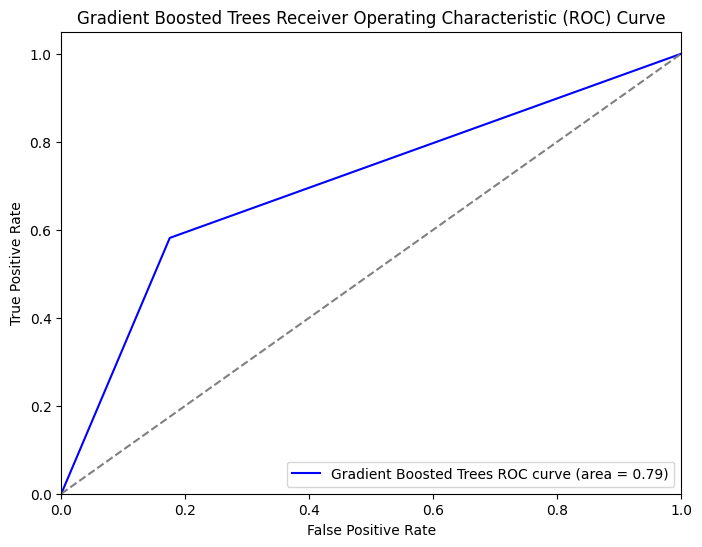

Gradient Boosted Trees AUC: 0.79389534883721



In [ ]:
gbt_classifier = GBTClassifier(featuresCol='features', labelCol='Label')
print("Evaluating Gradient Boosted Trees Classifier")
gbt_auc = evaluate_model(gbt_classifier, train_data, test_data, model_name="Gradient Boosted Trees")
print(f"Gradient Boosted Trees AUC: {gbt_auc}\n")

**Naive Bayes Classifier**

Evaluating Naive Bayes Classifier
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69        80
           1       0.43      0.44      0.44        43

    accuracy                           0.60       123
   macro avg       0.56      0.56      0.56       123
weighted avg       0.60      0.60      0.60       123



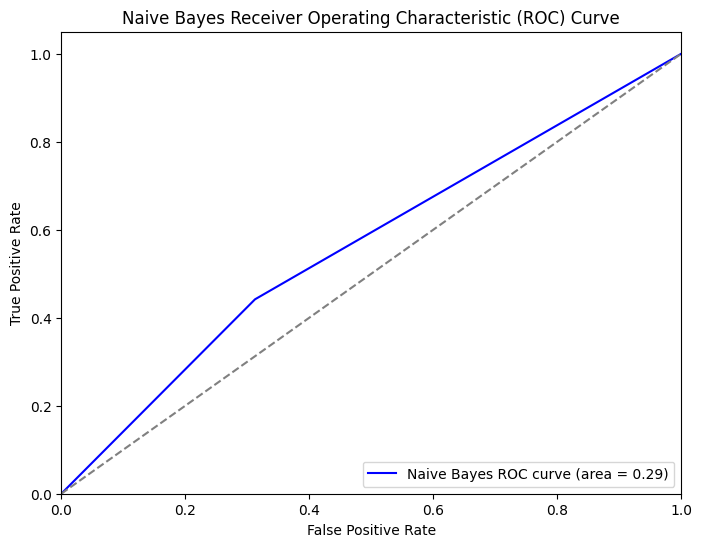

Naive Bayes AUC: 0.29418604651162794



In [ ]:
naive_bayes = NaiveBayes(featuresCol='features', labelCol='Label')
print("Evaluating Naive Bayes Classifier")
naive_bayes_auc = evaluate_model(naive_bayes, train_data, test_data, model_name="Naive Bayes")
print(f"Naive Bayes AUC: {naive_bayes_auc}\n")

**Support Vector Machine (SVM) Classifier**

Evaluating Support Vector Machine (SVM) Classifier
Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        80
           1       0.75      0.63      0.68        43

    accuracy                           0.80       123
   macro avg       0.78      0.76      0.77       123
weighted avg       0.79      0.80      0.79       123



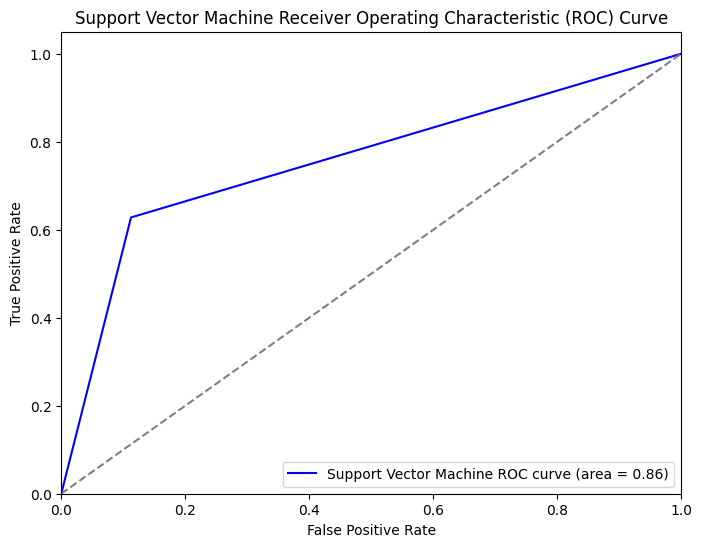

SVM AUC: 0.8636627906976743



In [ ]:
svm_classifier = LinearSVC(featuresCol='features', labelCol='Label')
print("Evaluating Support Vector Machine (SVM) Classifier")
svm_auc = evaluate_model(svm_classifier, train_data, test_data, model_name="Support Vector Machine")
print(f"SVM AUC: {svm_auc}\n")

**Hyperparameter Pada RandomForest**

Evaluating Random Forest Classifier
Random Forest Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        80
           1       0.78      0.58      0.67        43

    accuracy                           0.80       123
   macro avg       0.79      0.75      0.76       123
weighted avg       0.79      0.80      0.79       123



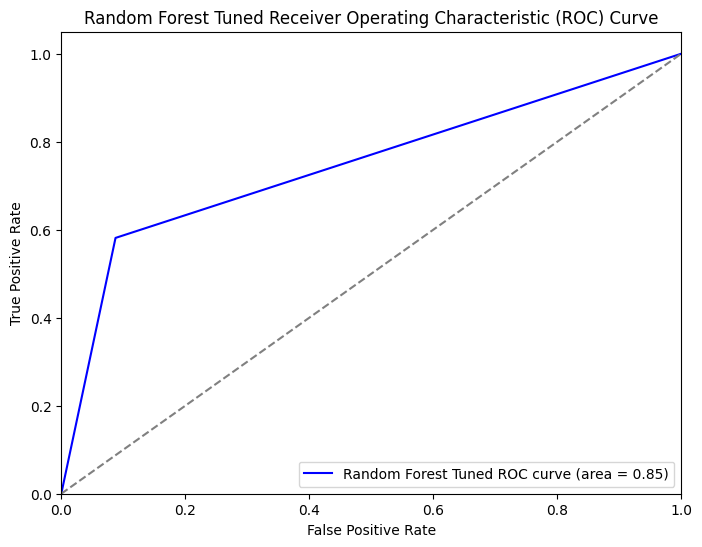

Random Forest AUC: 0.8517441860465116



In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="Label", metricName="areaUnderROC")

rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='Label')

rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf_classifier.numTrees, [100, 200, 300])  # Jumlah pohon
                 .addGrid(rf_classifier.maxDepth, [10, 15, 20])      # Kedalaman pohon lebih dalam
                 .addGrid(rf_classifier.maxBins, [32, 64])           # Jumlah bin
                 .addGrid(rf_classifier.minInstancesPerNode, [2, 4, 6])  # Minimum sampel di setiap node
                 .build())

rf_cv = CrossValidator(estimator=rf_classifier,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator,
                       numFolds=5)

print("Evaluating Random Forest Classifier")
rf_auc = evaluate_model(rf_cv, train_data, test_data, model_name="Random Forest Tuned")
print(f"Random Forest AUC: {rf_auc}\n")

**Hyperparameter Untuk Naive Bayes**

Evaluating Naive Bayes Classifier
Naive Bayes Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80        80
           1       0.62      0.60      0.61        43

    accuracy                           0.73       123
   macro avg       0.70      0.70      0.70       123
weighted avg       0.73      0.73      0.73       123



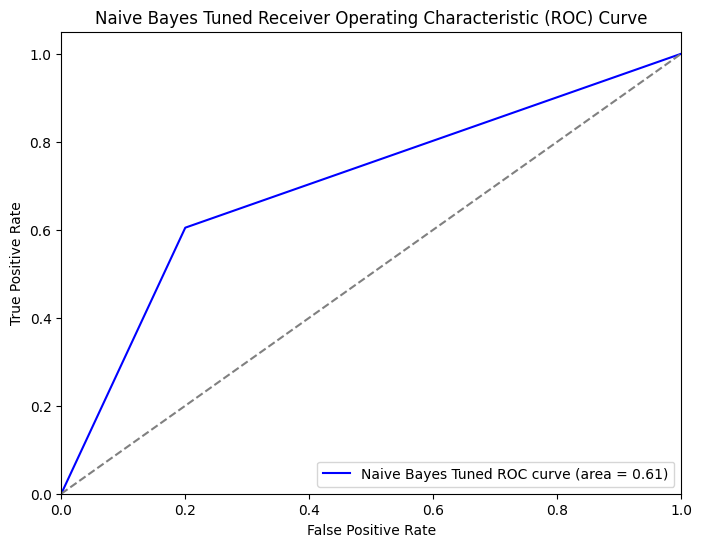

Naive Bayes AUC: 0.6093023255813955



In [ ]:
nb_classifier = NaiveBayes(featuresCol='features', labelCol='Label', modelType='gaussian')

evaluator = BinaryClassificationEvaluator(labelCol="Label", metricName="areaUnderROC")

paramGrid = (ParamGridBuilder()
             .addGrid(nb_classifier.smoothing, [1.0, 1.5, 2.0])
             .build())

crossval = CrossValidator(estimator=nb_classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

print("Evaluating Naive Bayes Classifier")
naive_bayes_auc = evaluate_model(crossval, train_data, test_data, model_name="Naive Bayes Tuned")
print(f"Naive Bayes AUC: {naive_bayes_auc}\n")

**Hyperparameter Untuk SVM**

Evaluating SVM Classifier
SVM Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80        80
           1       0.62      0.60      0.61        43

    accuracy                           0.73       123
   macro avg       0.70      0.70      0.70       123
weighted avg       0.73      0.73      0.73       123



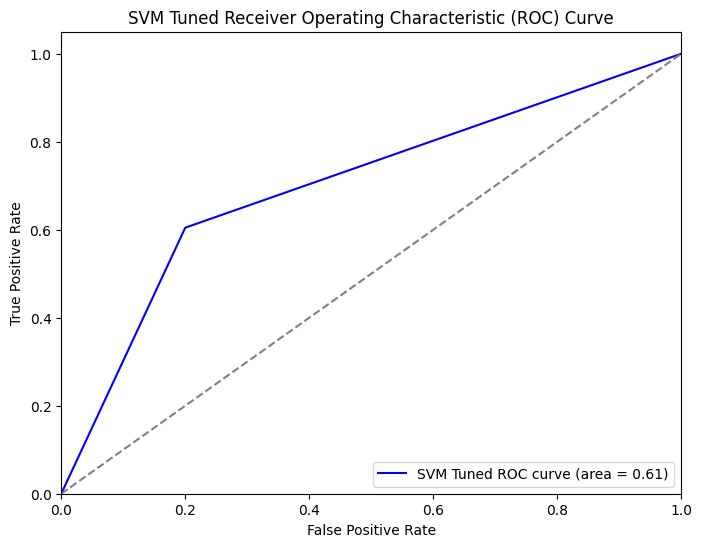

SVM AUC: 0.6093023255813955



In [ ]:
svm_classifier = LinearSVC(featuresCol='features', labelCol='Label')

svm_param_grid = (ParamGridBuilder()
                  .addGrid(svm_classifier.regParam, [0.1, 0.01, 0.001])  # Regularization parameter
                  .addGrid(svm_classifier.maxIter, [50, 100, 200])  # Jumlah iterasi
                  .addGrid(svm_classifier.tol, [1e-4, 1e-5])  # Toleransi konvergensi
                  .build())

svm_cv = CrossValidator(estimator=svm_classifier,
                        estimatorParamMaps=svm_param_grid,
                        evaluator=evaluator,
                        numFolds=5)

print("Evaluating SVM Classifier")
svm_auc = evaluate_model(crossval, train_data, test_data, model_name="SVM Tuned")
print(f"SVM AUC: {svm_auc}\n")